# Mineração - Aula 02

## Relatório sobre análise de reclamações

### Enunciado:
Utilizando o framework de análise descrito na aula passada e as técnicas de visualização apropriadas, faça uma análise sobre o dataset de reclamações do procon (link em anexo).
Eu quero saber quais empresas são mais odiadas.

Você deve entregar UM notebook jupyter com o relatório da sua análise. É para fazer descrições e visualizações, nada de fazer um monte de gráficos de qualquer jeito. Também não seja um robô, faça um relatório descrevendo seus pontos, os motivos que levam você a analisar ou concluir algo. Pense em setores, tipos de produtos, ... ou qualquer coisa que melhore meu entendimento sobre o problema. 

Assuma que sou uma besta acéfala que mal sabe ler (você não vai estar tão errado). Faça descrições cuidadosas e em "linguage humana".

### Dados:
https://www.kaggle.com/gerosa/procon/data

http://dados.gov.br/dataset/cadastro-nacional-de-reclamacoes-fundamentadas-procons-sindec1

#### Dicionario de dados:
http://dados.mj.gov.br/dataset/8ff7032a-d6db-452b-89f1-d860eb6965ff/resource/d87543d6-cf9d-4752-8f3c-1b0aa075dc45/download/dicionariodadossindec3-0.pdf

- Ano calendário de publicação do cadastro de reclamações fundamentadas:
2009: são 104.867 reclamações fundamentadas e arquivadas entre 09/2008 e 08/2009 de 39 Procons estaduais/municipais
2010: são 122.662 reclamações fundamentadas e arquivadas entre 09/2009 e 08/2010 de 52 Procons estaduais/municipais
2011: são 153.094 reclamações fundamentadas e arquivadas entre 01/2011 e 12/2011 de 67 Procons estaduais/municipais
2012: são 211.076 reclamações fundamentadas e arquivadas entre 01/2012 e 12/2012 de 112 Procons estaduais/municipais
- RadicalCNPJ: Aplica-se para pessoa jurídica e serve para agrupar as informações de um mesmo fornecedor (matriz e filiais), sendo os oitos primeiros dígitos do número do CNPJ - Exemplo: a matriz (central) do banco e suas filiais (agências)
- Faixa etária do consumidor distribuída da seguinte forma: até 20 anos, entre 21 e 30 anos, entre 31 e 40 anos, entre 41 e 50 anos, entre 51 e 60 anos, entre 61 e 70 anos, mais de 70 anos, Nao Informada (data de nascimento não informada no cadastro do consumidor), Não se aplica (são as reclamações (de ofício) em que o Procon é o reclamante)



### Passo 01 - Abrindo os arquivos com os dados a serem utilizados

In [1]:
%%time

## Mudar o endereço da pasta abaixo, caso queira mudar a pasta que receberá o arquivo pickle.
%cd C://_kopp//Dropbox//Filipe//_doutorado//Mineracao
from urllib.request import urlopen
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

pd.options.display.float_format = '{:.1f}'.format
plt.style.use('seaborn')  #plt.style.available
size = (10,6)

[WinError 2] O sistema não pode encontrar o arquivo especificado: 'C://_kopp//Dropbox//Filipe//_doutorado//Mineracao'
C:\_kopp\Dropbox\Filipe\_doutorado\PPGI\MINERACAO
Wall time: 1.8 s


In [2]:
## Dados de população de cada UF serão usados para normalizar algumas análises.
## source: https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o
populacao = {'AC': 831473, 'AL': 3378287, 'AP': 800567, 'AM': 4072343, 'BA': 15355449, 'CE': 9033796, 'DF': 3046233,
             'ES': 4019390, 'GO': 6792817, 'MA': 7004330, 'MT': 3350247, 'MS': 2718195, 'MG': 21140120, 'PA': 8377844,
             'PB': 4028416, 'PR': 11335726, 'PE': 9483440, 'PI': 3220991, 'RJ': 16736365, 'RN': 3512714, 'RS': 11333417,
             'RO': 1808986, 'RR': 524681, 'SC': 6994566, 'SP': 45162700, 'SE': 2292102, 'TO': 1553026}
pop  = pd.DataFrame.from_dict(populacao, orient='index')
print('população do Brasil:',sum(populacao.values()))
pop

população do Brasil: 207908221


,0
AC,831473
AL,3378287
AP,800567
AM,4072343
BA,15355449
CE,9033796
DF,3046233
ES,4019390
GO,6792817
MA,7004330


Os arquivos de dados do PROCON de 2009 a 2016 foram copiados para uma pasta Dropbox para poderem ser baixados automaticamente durante a execução do código. Na primeira vez que se executa o código, todos os arquivos são baixados, consolidados e salvos em um arquivo pickle. O arquivo pickle será utilizado nas futuras execuções com o objetivo de economizar tempo pois evita baixar os arquivos do PROCON novamente.

In [3]:
%%time
## Baixando os arquivos
urls = ['https://www.dropbox.com/s/lxq41kw10jwum6k/reclamacoes-fundamentadas-sindec-2009.csv?dl=1',
        'https://www.dropbox.com/s/48u53comem6vfqv/reclamacoes-fundamentadas-sindec-2010.csv?dl=1',
        'https://www.dropbox.com/s/ddsq2d9luyrelvd/reclamacoes-fundamentadas-sindec-2011.csv?dl=1',
        'https://www.dropbox.com/s/e9meajkvg3rb34v/reclamacoes-fundamentadas-sindec-2012.csv?dl=1',
        'https://www.dropbox.com/s/r89wzb1hmqyrzk7/reclamacoes-fundamentadas-sindec-2013.csv?dl=1',
        'https://www.dropbox.com/s/dcwtb62shu6zpws/reclamacoes-fundamentadas-sindec-2014.csv?dl=1',
        'https://www.dropbox.com/s/hsocwtkp53hon67/reclamacoes-fundamentadas-sindec-2015.csv?dl=1',
        'https://www.dropbox.com/s/4jx1g3aoze4lxmm/reclamacoes-fundamentadas-sindec-2016.csv?dl=1'] 
if os.path.isfile('reclama.pickle'):
    ## Se o arquivo pickle já existe, abrí-lo.
    print('pegando dados salvos no pickle')
    pd_reclama = pd.read_pickle('reclama.pickle')
else:
    ## Senão, baixar tudo e salvar em arquivo pickle.
    deli = 0
    pd_reclama = pd.DataFrame([])
    for url in urls:
        reclama_csv = urlopen(url)
        print('baixando dados de: ',url, end=' -> ')
        if deli < 3 : delim=';'
        else: delim = ','
        reclama_data = pd.read_csv(reclama_csv,delimiter=delim, dtype={0: str, 'NumeroCNPJ': str, 'RadicalCNPJ': str,
                                                                       'numeroCNPJ': str, 'radicalCNPJ': str,
                                                                       'CEPConsumidor': str}) 
        if deli < 3 : 
            reclama_data.rename(columns={'codigoregiao': 'CodigoRegiao','anocalendario': 'AnoCalendario',
                                         'radicalCNPJ': 'RadicalCNPJ', 'regiao': 'Regiao'}, inplace=True)
        deli += 1
        print(reclama_data.shape)
        pd_reclama = pd.concat([pd_reclama,reclama_data])
    pd_reclama.to_pickle('reclama.pickle')
print('total de linhas obtidas: ',pd_reclama.shape[0])
print('Arquivo pickle com ',int(os.stat('reclama.pickle').st_size/1024/1024)," MB.")

pegando dados salvos no pickle
total de linhas obtidas:  1586701
Arquivo pickle com  297  MB.
Wall time: 9.32 s


In [4]:
pd_reclama.dtypes

AnoCalendario             object
DataArquivamento          object
DataAbertura              object
CodigoRegiao             float64
Regiao                    object
UF                        object
strRazaoSocial            object
strNomeFantasia           object
Tipo                     float64
NumeroCNPJ                object
RadicalCNPJ               object
RazaoSocialRFB            object
NomeFantasiaRFB           object
CNAEPrincipal            float64
DescCNAEPrincipal         object
Atendida                  object
CodigoAssunto            float64
DescricaoAssunto          object
CodigoProblema           float64
DescricaoProblema         object
SexoConsumidor            object
FaixaEtariaConsumidor     object
CEPConsumidor             object
dtype: object

### Passo 02 - Organizando os dados

- Combinar colunas Razão Social com informações similares
- Normalizar a coluna Razão Social
- Corrigir SA e LTDA
- Diminuir tamaho das células em Faixa Etária

In [5]:
%%time
## Normalizando as Razões Sociais das empresas
pd_reclama['strRazaoSocial'].fillna(value=pd_reclama['RazaoSocialRFB'])
pd_reclama['strRazaoSocial'].fillna(value=pd_reclama['NomeFantasiaRFB'])
pd_reclama['strRazaoSocial'].fillna(value=pd_reclama['strNomeFantasia'])
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.replace('[^\w\s]',' ')
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.replace('\s\s+' ,' ')
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.strip()
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.upper()
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.normalize('NFKD').str.encode('ascii', 
                                                                errors='ignore').str.decode('utf-8')

## Padronizando SA e LTDA nos nomes das empresas
for s in [' S A']:
    pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.replace(s,' SA')
for s in [' LTDA ME',' LTDA EPP',' LTDAME']:
    pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.replace(s,' LTDA')

pd_reclama['FaixaEtariaConsumidor'] = pd_reclama['FaixaEtariaConsumidor'].str.replace('entre ','')
pd_reclama['FaixaEtariaConsumidor'] = pd_reclama['FaixaEtariaConsumidor'].str.replace(' anos','')

Wall time: 1min 1s


- Quebrar Data de Abertura e Data de Arquivamenteo em Ano e mês
- Calcular diferença entre datas em dias
- Criando variáveis binárias para sexo e atendimento
- Remover linhas sem CNPJ ou Razão Social. Remover reclamações que não são empresas (CPF).
- Remover colunas que não são mais usadas

In [6]:
%%time
## Ano da data de Arquivamento não é tão interessante quanto data de abertura da reclamação. Vamos trabalhar com ano e mês
## das duas datas e calcular a diferença entre elas em dias.
pd_reclama['DataAbertura'] = pd.to_datetime(pd_reclama['DataAbertura'],infer_datetime_format=True)
pd_reclama['ano_abertura'] = pd_reclama['DataAbertura'].dt.year
pd_reclama['mes_abertura'] = pd_reclama['DataAbertura'].dt.month

pd_reclama['DataArquivamento'] = pd.to_datetime(pd_reclama['DataArquivamento'],infer_datetime_format=True)
pd_reclama['ano_arquiva'] = pd_reclama['DataArquivamento'].dt.year
pd_reclama['mes_arquiva'] = pd_reclama['DataArquivamento'].dt.month

pd_reclama['diff'] = (pd_reclama['DataArquivamento'] - pd_reclama['DataAbertura']).dt.days


## Codificando Sexo e Atendipmento para 0 ou 1, para posteriormente calcular a média
pd_reclama['sexo_bin'] = np.nan
pd_reclama.loc[(pd_reclama['SexoConsumidor'] == 'M'),'sexo_bin'] = 1
pd_reclama.loc[(pd_reclama['SexoConsumidor'] == 'F'),'sexo_bin'] = 0
pd_reclama['atendimento_bin'] = (pd_reclama['Atendida'] == 'S')

## Mantendo somente as empresas e removendo colunas que não são mais necessárias
df_reclama = pd_reclama.copy()
df_reclama.drop(df_reclama[df_reclama.Tipo < 1].index, inplace=True) 
df_reclama.dropna(subset=['NumeroCNPJ','strRazaoSocial'], inplace=True)
df_reclama.drop(columns=['NomeFantasiaRFB', 'RazaoSocialRFB','CodigoRegiao','CodigoAssunto','AnoCalendario','DataAbertura',
                         'DataArquivamento','CodigoProblema','Tipo','CEPConsumidor','CNAEPrincipal','strNomeFantasia'], 
                inplace=True)
print('total de linhas após limpeza: ',df_reclama.shape[0])
print('total de linhas removidas: ',pd_reclama.shape[0] - df_reclama.shape[0], ' ou ', 
      round((pd_reclama.shape[0] - df_reclama.shape[0])/pd_reclama.shape[0] *100,2) , '%')

total de linhas após limpeza:  1495388
total de linhas removidas:  91313  ou  5.75 %
Wall time: 59.2 s


In [7]:
df_reclama.sort_values('NumeroCNPJ', inplace=True)
df_reclama

,Regiao,UF,strRazaoSocial,NumeroCNPJ,RadicalCNPJ,DescCNAEPrincipal,Atendida,DescricaoAssunto,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor,ano_abertura,mes_abertura,ano_arquiva,mes_arquiva,diff,sexo_bin,atendimento_bin
69853,Sudeste,ES,BANCO DO BRASIL SA UNIDADE DE OUVIDORIA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",N,Banco comercial,Cobrança indevida.,M,31 a 40,2011.0,2.0,2011.0,4.0,55.0,1.0,False
5856,Sudeste,MG,BANCO DO BRASIL SA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",S,Banco comercial,Cobrança indevida/abusiva,M,mais de 70,2016.0,2.0,2016.0,4.0,69.0,1.0,True
5776,Nordeste,CE,BANCO DO BRASIL SA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",S,Financeira,Cobrança indevida/abusiva,F,21 a 30,2016.0,6.0,2016.0,9.0,118.0,0.0,True
157112,Norte,PA,BANCO DO BRASIL SA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",N,Banco comercial,Cobrança indevida/abusiva,M,31 a 40,2016.0,2.0,2016.0,5.0,90.0,1.0,False
192406,Nordeste,PE,BANCO DO BRASIL SA END UNICO PARA CIP ELETRONICA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",N,Banco comercial,Cobrança indevida.,M,31 a 40,2012.0,1.0,2012.0,3.0,36.0,1.0,False
157142,Nordeste,PE,BANCO DO BRASIL SA END UNICO PARA CIP ELETRONICA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",S,Cartão de Crédito,Cobrança indevida/abusiva,M,31 a 40,2015.0,10.0,2016.0,5.0,207.0,1.0,True
5610,Norte,RO,BANCO DO BRASIL SA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",N,Banco comercial,Cobrança indevida/abusiva,F,61 a 70,2016.0,11.0,2016.0,12.0,29.0,0.0,False
83820,Sudeste,RJ,BANCO DO BRASIL SA UNIDADE DE OUVIDORIA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",S,Outros Contratos,Cobrança indevida.,F,31 a 40,2011.0,3.0,2011.0,7.0,107.0,0.0,True
84806,Nordeste,PE,BANCO DO BRASIL SA END UNICO PARA CIP ELETRONICA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",S,Financeira,Não entrega de copia do contrato,F,61 a 70,2015.0,3.0,2015.0,5.0,41.0,0.0,True
83866,Sudeste,ES,BANCO DO BRASIL SA UNIDADE DE OUVIDORIA,00000000000191,00000000,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",N,Cartão de Crédito,Cobrança indevida.,M,mais de 70,2011.0,1.0,2011.0,4.0,83.0,1.0,False


In [8]:
%%time
## Deve-se criar um dataframe somente com o RadicalCNPJ e Razão Social, e remover as duplicatas do RadicalCNPJ, assim,
## obtém-se um nome para cada grupo empresarial (matriz e filial)

df_empresas = df_reclama[['RadicalCNPJ','strRazaoSocial']].copy()
df_empresas.dropna(subset=['RadicalCNPJ','strRazaoSocial'], inplace=True, how='any')
df_empresas.sort_values(['RadicalCNPJ','strRazaoSocial'], ascending=True, inplace=True)
df_empresas.drop_duplicates(subset=['RadicalCNPJ'], keep='first', inplace=True)
print('Foram obtidos',df_empresas.shape[0],'grupos empresariais distintos, através do Radical CNPJ')
print(df_empresas.head())

Foram obtidos 80429 grupos empresariais distintos, através do Radical CNPJ
       RadicalCNPJ                                     strRazaoSocial
252672    00000000                                       BANCO BRASIL
34083     00000042                              AUTO POSTO GASOL LTDA
267428    00000208                     BANCO BRB BANCO DE BRASILIA SA
230824    00000246  DENTAL PREV PLANEJ E VENDA PLANOS ODONTOL S C ...
93876     00000439                                ALYSON GARCIA ALVES
Wall time: 5.46 s


In [9]:
%%time
df_resultado = pd.merge(df_reclama,df_empresas, on='RadicalCNPJ').sort_values(['RadicalCNPJ'])
df_resultado.rename(columns={'strRazaoSocial_y': 'razao','FaixaEtariaConsumidor': 'idade','SexoConsumidor': 'sexo'}, inplace=True)
#df_resultado.set_index(['razao'], inplace=True)
df_resultado.drop(columns=['strRazaoSocial_x', 'NumeroCNPJ','RadicalCNPJ'], inplace=True)

Wall time: 10.2 s


In [10]:
df_resultado

,Regiao,UF,DescCNAEPrincipal,Atendida,DescricaoAssunto,DescricaoProblema,sexo,idade,ano_abertura,mes_abertura,ano_arquiva,mes_arquiva,diff,sexo_bin,atendimento_bin,razao
0,Sudeste,ES,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",N,Banco comercial,Cobrança indevida.,M,31 a 40,2011.0,2.0,2011.0,4.0,55.0,1.0,False,BANCO BRASIL
9263,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,Cobrança indevida.,M,41 a 50,2009.0,4.0,2009.0,8.0,112.0,1.0,True,BANCO BRASIL
9264,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,"Contrato (não cumprimento, alteração, transfer...",M,51 a 60,2016.0,2.0,2016.0,11.0,279.0,1.0,True,BANCO BRASIL
9265,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,Calculo de prestação/taxa de juros,M,41 a 50,2015.0,8.0,2015.0,11.0,80.0,1.0,True,BANCO BRASIL
9266,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,Cobrança indevida.,M,Nao Informada,2012.0,5.0,2014.0,2.0,655.0,1.0,True,BANCO BRASIL
9267,Centro-oeste,MT,BANCOS COMERCIAIS,N,Cartão de Crédito,Não entrega do produto (titulo de capitalizaçã...,F,31 a 40,2012.0,9.0,2014.0,5.0,627.0,0.0,False,BANCO BRASIL
9268,Centro-oeste,MT,BANCOS COMERCIAIS,S,Cartão de Crédito,Tarifa de Cartão de Crédito – Cobrança Indevid...,M,21 a 30,2012.0,4.0,2014.0,4.0,703.0,1.0,True,BANCO BRASIL
9269,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,Cobrança indevida.,M,31 a 40,2012.0,4.0,2014.0,6.0,789.0,1.0,True,BANCO BRASIL
9270,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,"Contrato (não cumprimento, alteração, transfer...",M,51 a 60,2009.0,5.0,2009.0,7.0,84.0,1.0,True,BANCO BRASIL
9271,Centro-oeste,MT,BANCOS COMERCIAIS,N,Banco comercial,Cobrança indevida.,M,21 a 30,2012.0,3.0,2014.0,7.0,845.0,1.0,False,BANCO BRASIL


### Passo 03 - Pré-análise dos dados

In [11]:
df_resultado['razao'].groupby(df_resultado['Regiao']).describe()
## As regiões Nordeste e Sudeste são as que mais apresentam reclamações, sendo o Grupo OI o líder em ambas. 

,count,unique,top,freq
Regiao,,,,
Centro-oeste,241305,18675,BRASIL TELECOM,8201
Nordeste,516035,21444,GRUPO OI,16307
Norte,126897,7381,CELPA CENTRAIS ELETRICAS DO PARA,3598
Sudeste,504928,32748,GRUPO OI,18402
Sul,106223,10852,BRASIL TELECOM,6102


In [12]:
df_resultado['razao'].groupby(df_resultado['sexo']).describe()
## O sexo feminino é o que mais apresenta reclamação, e o Grupo OI também é o que representa mais reclamações em ambos.

,count,unique,top,freq
sexo,,,,
F,788831,48191,GRUPO OI,21024
M,697137,48300,GRUPO OI,15654
N,8455,4548,BANCO BMC SA,343


In [13]:
df_resultado['razao'].groupby(df_resultado['Atendida']).describe()
## Cerca de 63.5% das reclamações são atendidas. Essa média para o Grupo OI, que apresenta mais reclamações não atendidas 
## e atendidas é de cerca de 74.6%.

,count,unique,top,freq
Atendida,,,,
N,545425,46573,GRUPO OI,9304
S,949963,50866,GRUPO OI,27382


In [14]:
df_resultado['razao'].groupby(df_resultado['sexo_bin']).describe()
## 

,count,unique,top,freq
sexo_bin,,,,
0.0,788831,48191,GRUPO OI,21024
1.0,697137,48300,GRUPO OI,15654


In [15]:
piores_setores = df_resultado.groupby(['DescricaoAssunto','ano_abertura'])['razao'].count().unstack()
piores_setores = piores_setores.sort_values(by=[2016,2015], ascending=False).head(25)
piores_setores.drop(columns=range(2005,2010), inplace=True)
piores_setores
## Os piores setores identificados estão relacionados com telefonia fixa/celular e cartão de crédito/banco.

ano_abertura,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
DescricaoAssunto,,,,,,,
"Telefone ( Convencional, Celular, Interfone, Etc. )",15531.0,28648.0,19404.0,22579.0,19508.0,20018.0,12712.0
Telefonia Celular,7007.0,10931.0,11731.0,12692.0,12890.0,16877.0,10202.0
Cartão de Crédito,8113.0,10529.0,9104.0,8870.0,9864.0,13138.0,7274.0
Telefonia Fixa ( Plano de Expansão / Compra e Venda / Locação ),4814.0,7094.0,8226.0,13609.0,16526.0,14514.0,7137.0
Banco comercial,6533.0,9724.0,14548.0,17313.0,11701.0,8866.0,5017.0
Outros Contratos,2830.0,4438.0,5649.0,7210.0,5219.0,5707.0,4323.0
Energia Elétrica,2757.0,4003.0,4878.0,4960.0,4379.0,5866.0,3883.0
Microcomputador / Produtos de Informática,7688.0,13509.0,11930.0,17135.0,20662.0,11145.0,3766.0
"TV Por Assinatura ( Cabo, Satélite, Etc. )",1150.0,1469.0,3582.0,5388.0,6686.0,10077.0,3734.0


In [16]:
piores_empresas = df_resultado.groupby(['razao','ano_abertura'])['razao'].count().unstack()
piores_empresas = piores_empresas.sort_values(by=[2016,2015], ascending=False).head(100)
piores_empresas.drop(columns=range(2005,2010), inplace=True)
piores_empresas
## As piores empresas identificadas foram Americel, Barateiro, Oi e Tim. O Barateiro não estava nas maiores 
## posições até ano passado. As informações de 2016 ainda são parciais.

ano_abertura,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
razao,,,,,,,
AMERICEL SA,1567.0,2537.0,4201.0,4221.0,3529.0,7928.0,4010.0
BARATEIRO COM BR,1.0,nan,1.0,16.0,96.0,1869.0,3278.0
GRUPO OI,2490.0,3452.0,4215.0,5845.0,8012.0,5605.0,3226.0
TIM,1378.0,2660.0,2404.0,2700.0,3233.0,5272.0,2644.0
14 BRASIL TELECOM CELULAR,827.0,690.0,853.0,2033.0,4224.0,4386.0,2527.0
SAMSUNG,3039.0,3718.0,2179.0,4237.0,4568.0,3510.0,2422.0
ATENTO EMPRESA AUTORIZADA,414.0,839.0,827.0,1549.0,3410.0,3536.0,2378.0
SKY,333.0,591.0,2324.0,2674.0,3795.0,6367.0,2053.0
A VAREJO SA,2068.0,2956.0,1951.0,2437.0,3307.0,4049.0,2048.0


Sexo feminino apresenta  53.33563313810676 % das reclamações


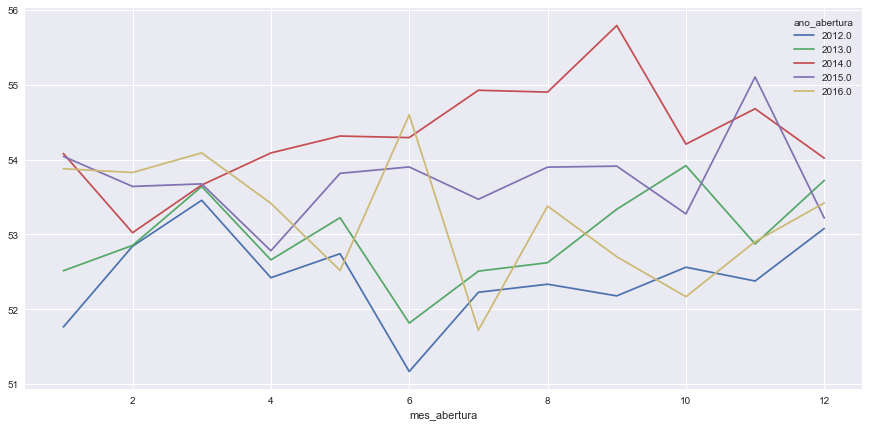

In [17]:
## Existe alguma diferença de reclamações por causa do sexo? 
## Aparentemente, o sexo Feminino 
agrupado_M = df_resultado[(df_resultado['sexo'] == 'M') & (df_resultado['ano_abertura'] >= 2012)].groupby([ 'mes_abertura','ano_abertura'])['razao'].count().unstack()
agrupado_F = df_resultado[(df_resultado['sexo'] == 'F') & (df_resultado['ano_abertura'] >= 2012)].groupby([ 'mes_abertura','ano_abertura'])['razao'].count().unstack()
sexo = agrupado_F/(agrupado_M + agrupado_F) * 100
print('Sexo feminino apresenta ',sexo.mean().mean(),'% das reclamações')
sexo.plot(figsize=(15,7))

A taxa média de atendimento é de  64.6941818574984 % das reclamações


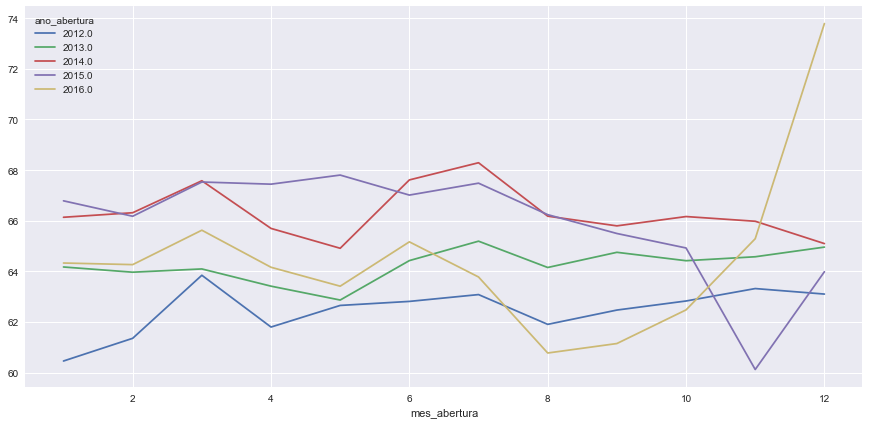

In [18]:
agrupado_S = df_resultado[(df_resultado['Atendida'] == 'S') & (df_resultado['ano_abertura'] >= 2012)].groupby([ 'mes_abertura','ano_abertura'])['razao'].count().unstack()
agrupado_N = df_resultado[(df_resultado['Atendida'] == 'N') & (df_resultado['ano_abertura'] >= 2012)].groupby([ 'mes_abertura','ano_abertura'])['razao'].count().unstack()
atendida = agrupado_S/(agrupado_S + agrupado_N) * 100
print('A taxa média de atendimento é de ',atendida.mean().mean(),'% das reclamações')
atendida.plot(figsize=(15,7))
## As reclamações abertas em Junho/Julho possivelmente possuem taxa de atendimento ligeiramente maior que a média. 

## Passo 04 - Desenhando os gráficos

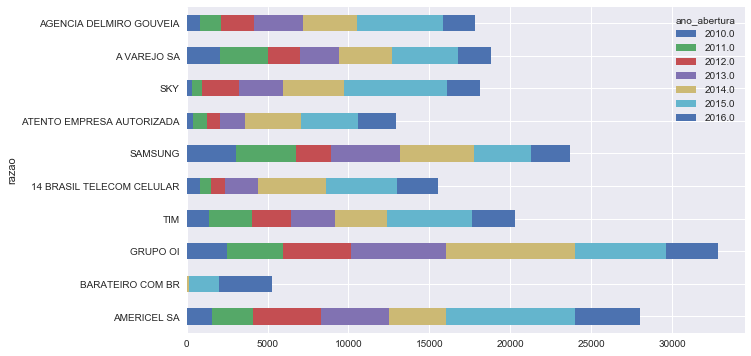

In [19]:
piores_empresas.head(10).plot.barh(figsize=size, stacked=True)

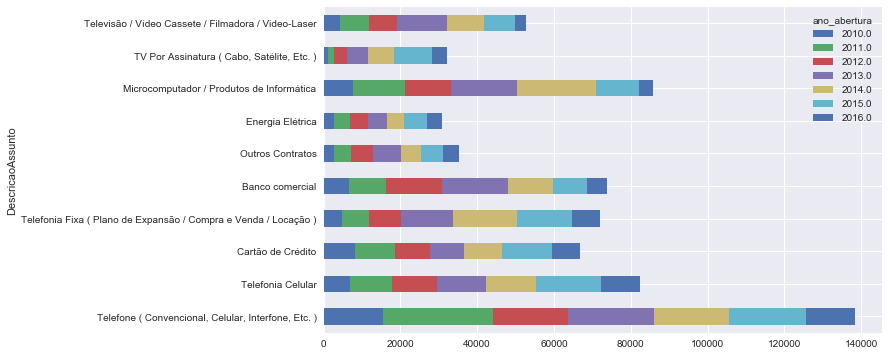

In [20]:
piores_setores.head(10).plot.barh(figsize=size, stacked=True)

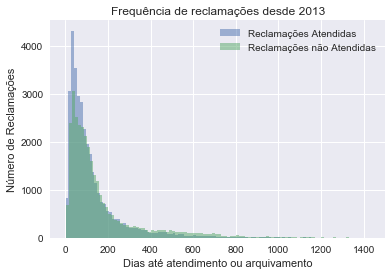

In [21]:
values_atendido   = df_resultado[(df_resultado['ano_abertura'] >= 2013) & 
                                 (df_resultado['atendimento_bin'] == 1)].groupby('razao')['diff'].mean().sort_values(
    ascending=False)
values_atendido = values_atendido[values_atendido > 0]

values_n_atendido = df_resultado[(df_resultado['ano_abertura'] >= 2013) & 
                                 (df_resultado['atendimento_bin'] == 0)].groupby('razao')['diff'].mean().sort_values(
    ascending=False)
values_n_atendido = values_n_atendido[values_n_atendido > 0]

plt.hist(values_atendido, 100, alpha=0.5, label='Reclamações Atendidas')
plt.hist(values_n_atendido, 100, alpha=0.5, label='Reclamações não Atendidas')
plt.xlabel("Dias até atendimento ou arquivamento")
plt.ylabel("Número de Reclamações")
plt.title('Frequência de reclamações desde 2013')
plt.legend(loc='upper right')
plt.show()

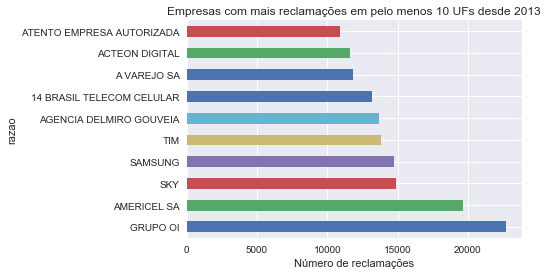

In [22]:
empresas_por_uf = df_resultado[df_resultado.ano_abertura >= 2013].groupby(['razao','UF'])['razao'].count().unstack()
empresas_por_uf.dropna(thresh=10, inplace=True)
empresas_por_uf['total'] = empresas_por_uf.sum(axis=1)
empresas_por_uf.sort_values('total', ascending=False, inplace=True)

plt.xlabel("Número de reclamações")
plt.ylabel("Empresas mais reclamadas")
plt.title('Empresas com mais reclamações em pelo menos 10 UFs desde 2013')
empresas_por_uf['total'].head(10).plot.barh()
plt.show()

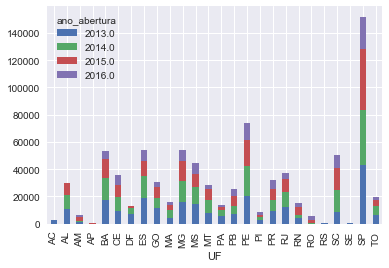

In [23]:
reclama_uf = df_resultado[df_resultado.ano_abertura >= 2013].groupby(['UF','ano_abertura'])['razao'].count().unstack()
reclama_uf.plot.bar(stacked=True)
## Devido ao baixo número de reclamações de AP, RS e SE, supeita-se que não há informações para essas UFs.
## UFs x Número de Reclamações, Reclamações por UF desde 2013

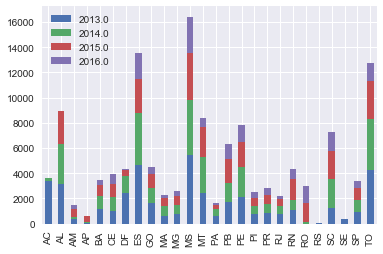

In [24]:
reclama_uf_pop = pd.merge(reclama_uf,pop,left_index=True,right_index=True)
for i in range(2013,2017):
    reclama_uf_pop[i] = reclama_uf_pop[i] / reclama_uf_pop[0] * 1000000
reclama_uf_pop.drop(columns=[0], inplace=True)
reclama_uf_pop.plot.bar(stacked=True)
## UFs x Número de Reclamações por 1.000.000 hab, Reclamações por UF desde 2013